Team Member:- Darshan, Krupal, Swayam, Sanyami, Dhrumil |
Subject:- AI 700 Deep Learning


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_dir = 'KLGrade_dataset'

# List of class labels
class_labels = ['0', '1', '2', '3', '4']

# DataFrame with file paths and labels.
data = []
for label in class_labels:
    folder_path = os.path.join(data_dir, label)
    image_files = glob.glob(os.path.join(folder_path, '*.png')) + glob.glob(os.path.join(folder_path, '*.jpg'))
    for file in image_files:
        data.append({'filepath': file, 'label': label})
        
df = pd.DataFrame(data)
print("Total images loaded:", len(df))
print(df.head())

Total images loaded: 4394
                               filepath label
0    KLGrade_dataset\0\NormalG0 (1).png     0
1   KLGrade_dataset\0\NormalG0 (10).png     0
2  KLGrade_dataset\0\NormalG0 (100).png     0
3  KLGrade_dataset\0\NormalG0 (101).png     0
4  KLGrade_dataset\0\NormalG0 (102).png     0


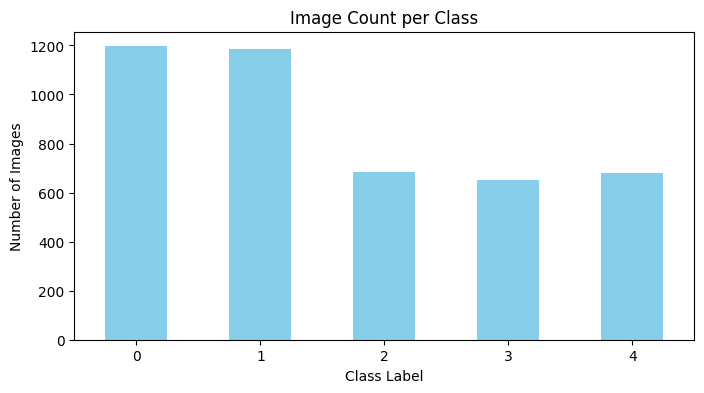

In [4]:
class_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

In [5]:
# split into train and test
train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))
print(train_df)

Training set size: 3515
Validation set size: 439
Test set size: 440
                                               filepath label
2872  KLGrade_dataset\2\grade_2_198_png.rf.a2436ffe2...     2
3509  KLGrade_dataset\3\grade_3_185_png.rf.121990216...     3
480                KLGrade_dataset\0\NormalG0 (588).png     0
182                KLGrade_dataset\0\NormalG0 (263).png     0
2127  KLGrade_dataset\1\grade_1_141_png.rf.c45e17057...     1
...                                                 ...   ...
3372               KLGrade_dataset\3\ModerateG3 (6).png     3
617                KLGrade_dataset\0\NormalG0 (710).png     0
4166  KLGrade_dataset\4\grade_4_135_png.rf.0dac20188...     4
2442                 KLGrade_dataset\2\MildG2 (152).png     2
3068             KLGrade_dataset\3\ModerateG3 (100).png     3

[3515 rows x 2 columns]


Model Architecture

In [6]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features,  len(class_labels))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

class_counts = train_df['label'].value_counts().sort_index()
class_weights = [len(train_df) / (len(class_labels) * class_counts[str(i)]) for i in range(len(class_labels))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

cuda
Class weights: tensor([0.7346, 0.7400, 1.2875, 1.3519, 1.2970], device='cuda:0')


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# Create dataset & DataLoaders
train_dataset = KneeDataset(train_df, transform=train_transform)
val_dataset = KneeDataset(val_df, transform=validation_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

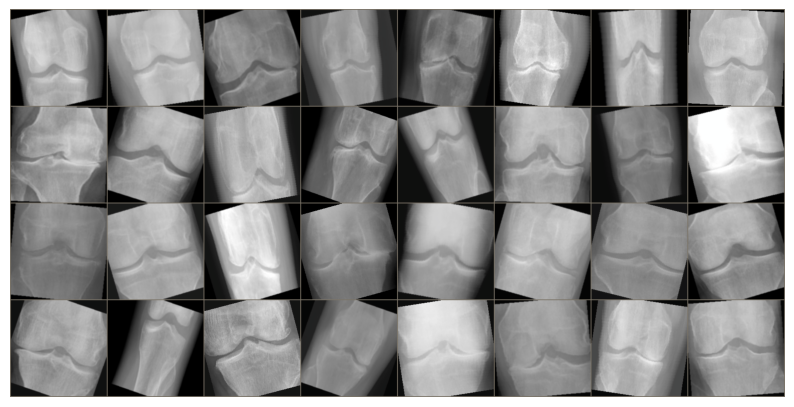

In [11]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

images, labels = next(iter(train_loader))
out = utils.make_grid(images)
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()

Model Training & Evaluation 

In [ ]:
num_epochs = 25

train_losses = []
train_accuracies = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = torch.tensor([int(label) for label in labels], dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch [1/25]: 100%|██████████| 110/110 [01:04<00:00,  1.71it/s, loss=0.5220, acc=78.35%]


Epoch [1/25], Loss: 0.4983, Accuracy: 0.7835


Epoch [2/25]: 100%|██████████| 110/110 [01:03<00:00,  1.74it/s, loss=0.4626, acc=78.04%]


Epoch [2/25], Loss: 0.5124, Accuracy: 0.7804


Epoch [3/25]: 100%|██████████| 110/110 [01:05<00:00,  1.67it/s, loss=0.1950, acc=78.75%]


Epoch [3/25], Loss: 0.4874, Accuracy: 0.7875


Epoch [4/25]: 100%|██████████| 110/110 [01:06<00:00,  1.66it/s, loss=0.4846, acc=79.06%]


Epoch [4/25], Loss: 0.4770, Accuracy: 0.7906


Epoch [5/25]: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s, loss=0.7151, acc=78.35%]


Epoch [5/25], Loss: 0.4856, Accuracy: 0.7835


Epoch [6/25]: 100%|██████████| 110/110 [00:59<00:00,  1.84it/s, loss=0.3563, acc=80.06%]


Epoch [6/25], Loss: 0.4425, Accuracy: 0.8006


Epoch [7/25]: 100%|██████████| 110/110 [00:59<00:00,  1.84it/s, loss=0.2906, acc=80.31%]


Epoch [7/25], Loss: 0.4394, Accuracy: 0.8031


Epoch [8/25]: 100%|██████████| 110/110 [00:59<00:00,  1.85it/s, loss=0.3895, acc=80.43%]


Epoch [8/25], Loss: 0.4235, Accuracy: 0.8043


Epoch [9/25]: 100%|██████████| 110/110 [00:59<00:00,  1.86it/s, loss=0.4946, acc=81.19%]


Epoch [9/25], Loss: 0.4327, Accuracy: 0.8119


Epoch [10/25]: 100%|██████████| 110/110 [00:59<00:00,  1.86it/s, loss=0.5615, acc=80.77%]


Epoch [10/25], Loss: 0.4448, Accuracy: 0.8077


Epoch [11/25]: 100%|██████████| 110/110 [00:58<00:00,  1.87it/s, loss=0.4391, acc=82.05%]


Epoch [11/25], Loss: 0.4085, Accuracy: 0.8205


Epoch [12/25]: 100%|██████████| 110/110 [00:59<00:00,  1.86it/s, loss=0.2999, acc=81.25%]


Epoch [12/25], Loss: 0.4250, Accuracy: 0.8125


Epoch [13/25]: 100%|██████████| 110/110 [00:59<00:00,  1.86it/s, loss=0.5065, acc=82.73%]


Epoch [13/25], Loss: 0.3909, Accuracy: 0.8273


Epoch [14/25]: 100%|██████████| 110/110 [00:59<00:00,  1.85it/s, loss=0.3476, acc=82.05%]


Epoch [14/25], Loss: 0.4108, Accuracy: 0.8205


Epoch [15/25]: 100%|██████████| 110/110 [00:59<00:00,  1.86it/s, loss=0.6008, acc=83.36%]


Epoch [15/25], Loss: 0.3688, Accuracy: 0.8336


Epoch [16/25]: 100%|██████████| 110/110 [00:59<00:00,  1.85it/s, loss=0.3650, acc=83.56%]


Epoch [16/25], Loss: 0.3713, Accuracy: 0.8356


Epoch [17/25]: 100%|██████████| 110/110 [00:59<00:00,  1.85it/s, loss=0.6716, acc=83.56%]


Epoch [17/25], Loss: 0.3948, Accuracy: 0.8356


Epoch [18/25]: 100%|██████████| 110/110 [01:01<00:00,  1.80it/s, loss=0.3897, acc=83.53%]


Epoch [18/25], Loss: 0.3652, Accuracy: 0.8353


Epoch [19/25]: 100%|██████████| 110/110 [00:59<00:00,  1.85it/s, loss=0.2505, acc=83.58%]


Epoch [19/25], Loss: 0.3597, Accuracy: 0.8358


Epoch [20/25]: 100%|██████████| 110/110 [01:04<00:00,  1.69it/s, loss=0.4212, acc=83.93%]


Epoch [20/25], Loss: 0.3633, Accuracy: 0.8393


Epoch [21/25]: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s, loss=0.2686, acc=84.58%]


Epoch [21/25], Loss: 0.3349, Accuracy: 0.8458


Epoch [22/25]: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s, loss=0.4710, acc=83.76%]


Epoch [22/25], Loss: 0.3837, Accuracy: 0.8376


Epoch [23/25]: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s, loss=0.3492, acc=85.43%]


Epoch [23/25], Loss: 0.3428, Accuracy: 0.8543


Epoch [24/25]: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s, loss=0.5077, acc=84.35%]


Epoch [24/25], Loss: 0.3280, Accuracy: 0.8435


Epoch [25/25]: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s, loss=0.1749, acc=85.55%]

Epoch [25/25], Loss: 0.3208, Accuracy: 0.8555


In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = torch.tensor([int(label) for label in labels], dtype=torch.long).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, accuracy, all_labels, all_preds


In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Evaluation on Validation Set
val_loss, val_accuracy, val_labels, val_preds = evaluate_model(model, val_loader, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds))


Validation Loss: 0.3854, Validation Accuracy: 0.8357

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       119
           1       0.88      0.73      0.80       118
           2       0.70      0.74      0.72        69
           3       0.84      0.80      0.82        65
           4       0.97      0.93      0.95        68

    accuracy                           0.83       439
   macro avg       0.83      0.83      0.83       439
weighted avg       0.83      0.83      0.83       439



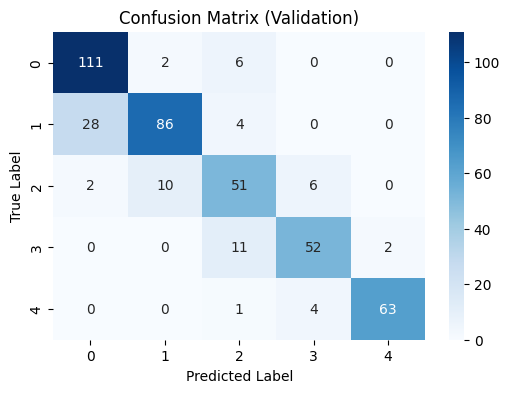

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(val_labels), yticklabels=np.unique(val_labels))
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()